In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras import backend as K
from keras.layers import Layer, Input, Conv2D, MaxPooling2D
import tensorflow as tf

In [2]:
#base_model test
import base_model
base = base_model.Base()
fmap = base.get_fmap()
base.get_config()

{'name': 'base',
 'trainable': True,
 'dtype': 'float32',
 'base': 'VGG16',
 'channels': 3,
 'input_shape': TensorShape([None, None, None, 3]),
 'fmap_shape': TensorShape([None, None, None, 512])}

In [3]:
#pooling test
import roi_pooling

#test pool.call after the rois are generated
pool = roi_pooling.RoIPooling(pool_size = 7, num_rois = 1)
pool.get_config()

{'name': 'ro_i_pooling',
 'trainable': True,
 'dtype': 'float32',
 'pool_size': 7,
 'num_rois': 1}

## Testing Region Proposals (generate.py)

(640, 640, 3)


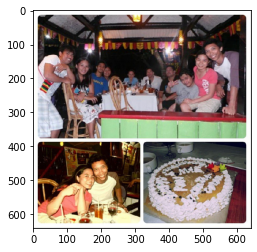

In [4]:
#rpn proposals
from rpn.generate import generate_anchor_boxes
import config as C
img = cv2.imread("test_img/10245691204_98dce75b5a_o.jpg")
bbox = pd.read_csv("test_img/test_bbox.csv")
cls_labels = pd.read_csv("test_img/class_labels.csv")
plt.imshow(img[:,:,[2,1,0]])
print(img.shape)

In [5]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
bbox

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
5,000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
6,000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
7,000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
8,000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
9,000002b66c9c498e,xclick,/m/04bcr3,1,0.301562,0.990625,0.462500,0.595312,0,0,0,0,0


In [6]:
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
cls_labels

,Name,Class
0,/m/01g317,Person
1,/m/0284d,Dairy
2,/m/04bcr3,Table
3,/m/0fszt,Cake
4,/m/0hnyx,Pastry


In [7]:
imdb = pd.DataFrame()
imdb[['x1','y1','x2','y2']] = bbox[['XMin','YMin','XMax','YMax']]*640
imdb['class']=bbox.join(cls_labels.set_index('Name'),on='LabelName')['Class']
imdb

,x1,y1,x2,y2,class
0,8.00000,95.00032,124.99968,376.00000,Person
1,16.00000,457.00032,177.00032,607.00032,Person
2,96.99968,126.99968,198.99968,378.00000,Person
3,164.00000,417.00032,275.00032,592.00000,Person
4,164.99968,151.00032,222.00000,247.00032,Person
5,204.99968,167.00032,236.00000,210.00000,Person
6,264.00000,76.99968,604.99968,304.00000,Person
7,338.00000,432.00000,590.99968,617.00032,Dairy
8,40.99968,569.00032,315.00032,636.00000,Table
9,192.99968,296.00000,634.00000,380.99968,Table


In [8]:
imdb['class'].loc[imdb['class']!='Person']='bg'
imdb

C:\Users\april\Anaconda3\envs\obj-detection\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,x1,y1,x2,y2,class
0,8.00000,95.00032,124.99968,376.00000,Person
1,16.00000,457.00032,177.00032,607.00032,Person
2,96.99968,126.99968,198.99968,378.00000,Person
3,164.00000,417.00032,275.00032,592.00000,Person
4,164.99968,151.00032,222.00000,247.00032,Person
5,204.99968,167.00032,236.00000,210.00000,Person
6,264.00000,76.99968,604.99968,304.00000,Person
7,338.00000,432.00000,590.99968,617.00032,bg
8,40.99968,569.00032,315.00032,636.00000,bg
9,192.99968,296.00000,634.00000,380.99968,bg


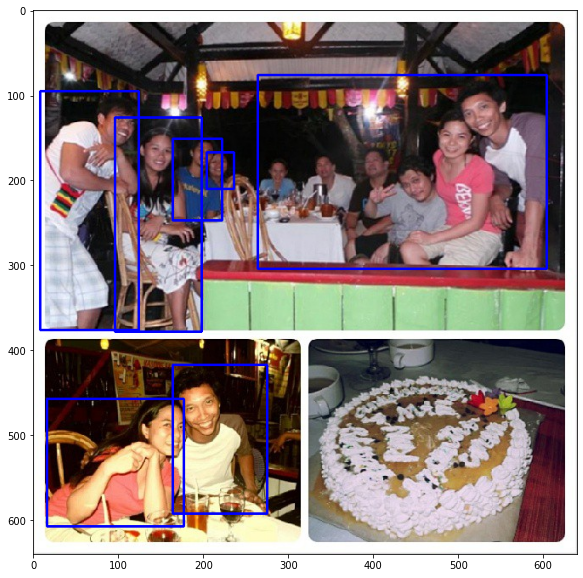

In [9]:
#plotting rectangles
for idx in range(len(imdb)):
    im = imdb.loc[idx]
    #print(im['x1'],im['y1'],im['x2'],im['y2'])
    if im['class']!='bg':
        cv2.rectangle(img,(int(im['x1']),int(im['y1'])),(int(im['x2']),int(im['y2'])),(255,0,0),2)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,[2,1,0]])

In [10]:
y_rpn_cls, y_rpn_regr, num_pos = generate_anchor_boxes(imdb,640,640,640,640)

In [11]:
print(y_rpn_cls.shape, y_rpn_regr.shape, num_pos)

(1, 40, 40, 18) (1, 40, 40, 72) 12


In [12]:
anchor_ratios = C.anchor_box_ratios
anchor_scales = C.anchor_box_scales
pos_cnt,neg_cnt=0,0
downscale = C.rpn_stride
bboxes = np.where(y_rpn_cls[:,:,:,:9])
for i in range(len(bboxes[0])):
    w_idx, h_idx = bboxes[1][i], bboxes[2][i]
    if y_rpn_cls[0,w_idx,h_idx,bboxes[3][i]+9]:
        bbox_type='pos'
        pos_cnt+=1
    else:
        bbox_type='neg'
        neg_cnt+=1
    anchor_scale_idx = bboxes[3][i]//len(anchor_ratios)
    anchor_ratio_idx = bboxes[3][i]%len(anchor_ratios)
    w = anchor_scales[anchor_scale_idx]*anchor_ratios[anchor_ratio_idx][0]
    h = anchor_scales[anchor_scale_idx]*anchor_ratios[anchor_ratio_idx][1]
    x1 = int(downscale*w_idx - w/2)
    y1 = int(downscale*h_idx - h/2)
    x2 = int(downscale*w_idx + w/2)
    y2 = int(downscale*h_idx + h/2)
    if bbox_type=='pos':
        color = (0,255,0)
    #else:
    #    color = (0,0,255)
        cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
print("pos_cnt: {}, neg_cnt: {}".format(pos_cnt, neg_cnt))

pos_cnt: 12, neg_cnt: 244


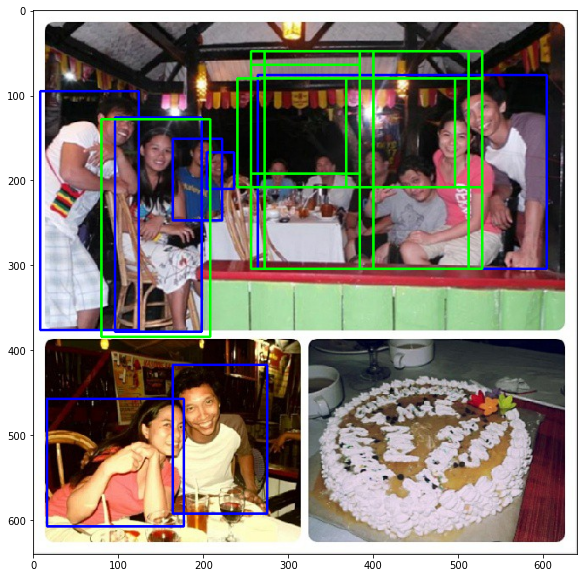

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,[2,1,0]])